# Initiating Environment for kaggle and fetching the dataset

In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c nlp-competition-cuet-ete-day-2023
!unzip nlp-competition-cuet-ete-day-2023.zip

!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [3]:
!pip install seaborn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json, pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(42)
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 4.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


# Initializing training & test dataset

In [4]:
train= pd.read_csv('/kaggle/input/infixon-train-test-dataset/train.csv')
test= pd.read_csv('/kaggle/input/infixon-train-test-dataset/test.csv')

In [5]:
train.head()

,summary,genre,Label
0,#BookReview\r\n\r\nবইঃ চাঁদের পাহাড়\r\nধরনঃ অ...,Childrens-Book,2
1,বেশির ভাগ বই ই আমার ভাললাগে। কিন্তু এই টাইপের ...,Fiction,0
2,মিসির আলি এখন তার ছাত্র ফারুকের শ্বশুর বাড়ি কই...,Fiction,0
3,ছোটজাতের ছোটজাত হাসিম। পিতৃপ্রদত্ত নামখানা একর...,Fiction,0
4,ফালতু একটা বই। পয়সা নষ্ট। বাজে লেখনী। একই জিনি...,Political,3


In [6]:
train = train.drop('genre', axis=1)

In [7]:
train

,summary,Label
0,#BookReview\r\n\r\nবইঃ চাঁদের পাহাড়\r\nধরনঃ অ...,2
1,বেশির ভাগ বই ই আমার ভাললাগে। কিন্তু এই টাইপের ...,0
2,মিসির আলি এখন তার ছাত্র ফারুকের শ্বশুর বাড়ি কই...,0
3,ছোটজাতের ছোটজাত হাসিম। পিতৃপ্রদত্ত নামখানা একর...,0
4,ফালতু একটা বই। পয়সা নষ্ট। বাজে লেখনী। একই জিনি...,3
...,...,...
3882,"বিশ্ববিদ্যালয়ের অভ্যন্তরীণ কিছু ঘটনা, কিছু মা...",0
3883,২০০৫ সালে সপ্তম শ্রেণীতে উঠে সাপ্তাহিক বই পড়া ...,4
3884,আবহমান গ্রাম বাংলার একটি একান্নবর্তী পরিবারের ...,0
3885,আমার মত যারা ৯০'র দশকে জন্ম তারা আমরা অনেকেই ১...,3


# EDA

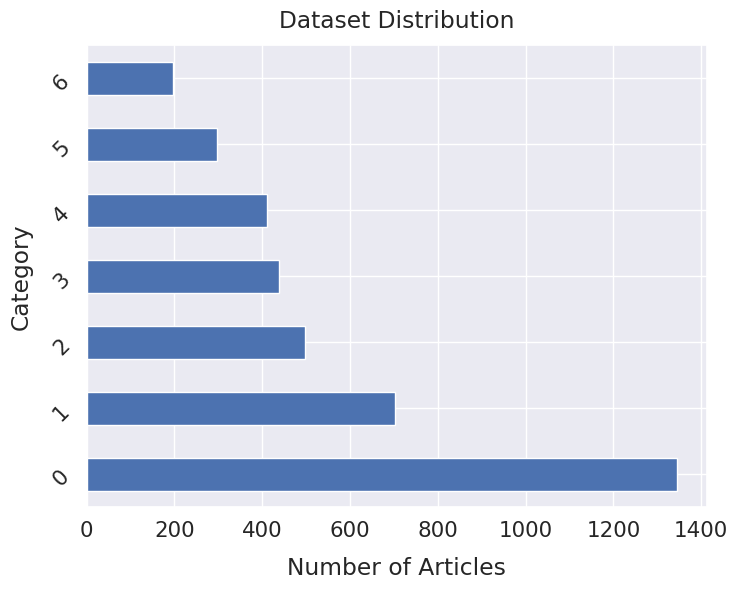

In [8]:
# Plot the Class distribution
sns.set(font_scale=1.4)
train ['Label'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Number of Articles", labelpad=12)
plt.ylabel("Category", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

The dataset has total 7 genres data and 0 class or fiction has maximum number of articles

In [9]:
'''columns=["summary","Label"]
dataset=train[columns]
dataset_test= test[["summary","Id"]]'''


'columns=["summary","Label"]\ndataset=train[columns]\ndataset_test= test[["summary","Id"]]'

# **Data Preparation and Cleaning**

In [10]:
!pip install langid
import langid
import re

def cleaning(row):
    # Check if the input is a string
    if isinstance(row, str):
        lang, _ = langid.classify(row)
        if lang == 'bn':  # Bangla text
            text = re.sub('[^\u0980-\u09FF]', ' ', row)  # Removing non-Bangla characters
            return text
        elif lang == 'en':  # English text
            return row
    return ''  # Return an empty string for non-string inputs or other languages




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941172 sha256=a873fd3ed0e0be5786a979b91fbb7a88f28ebae65d8690b63e21b092cafd5f7a
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [11]:
# Apply the cleaning function to the 'summary' column, handling non-string values
train['cleaned'] = train['summary'].apply(lambda x: cleaning(x) if isinstance(x, str) else '')

# Display the DataFrame with the 'cleaned' column
train.head()

,summary,Label,cleaned
0,#BookReview\r\n\r\nবইঃ চাঁদের পাহাড়\r\nধরনঃ অ...,2,বইঃ চাঁদের পাহাড় ধরনঃ অ্যাডভে...
1,বেশির ভাগ বই ই আমার ভাললাগে। কিন্তু এই টাইপের ...,0,বেশির ভাগ বই ই আমার ভাললাগে কিন্তু এই টাইপের ...
2,মিসির আলি এখন তার ছাত্র ফারুকের শ্বশুর বাড়ি কই...,0,মিসির আলি এখন তার ছাত্র ফারুকের শ্বশুর বাড়ি কই...
3,ছোটজাতের ছোটজাত হাসিম। পিতৃপ্রদত্ত নামখানা একর...,0,ছোটজাতের ছোটজাত হাসিম পিতৃপ্রদত্ত নামখানা একর...
4,ফালতু একটা বই। পয়সা নষ্ট। বাজে লেখনী। একই জিনি...,3,ফালতু একটা বই পয়সা নষ্ট বাজে লেখনী একই জিনি...


In [12]:
## Printing the raw dataset
for i in list(np.random.randint(1,len(train),10)):
  print(train['cleaned'][i],"\n",train['Label'][i])
  print('\n')

 রকমারি বইপোকা রিভিউ প্রতিযোগিতা বই যকের ধন লেখক হেমেন্দ্রকুমার রায় পৃষ্ঠা ৯২ মূল্য ১২০টাকা প্রকাশনী বিশ্বসাহিত্য কেন্দ্র হেমন্দ্রকুমার রায় একজন বাঙালি সাহিত্যিক এবং গীতিকার  এই লেখক মাত্র চোদ্দ বছর বয়সে সাহিত্যচর্চা শুরু করেন   কিশোরদের জন্য তিনি লিখেছেন ১০০ টিরও বেশি বই   তাঁর সৃষ্ট দুঃসাহসী বিমল কুমার  জয়ন্ত  গোয়েন্দা  ও সহকারী মানিক  পুলিশ ইন্সপেক্টর সুন্দরবাবু  ডিটেকটিভ হেমন্ত  বাংলা কিশোর সাহিত্যে বিশেষ উল্লেখযোগ্য চরিত্র  তাঁর  সিঁদুর চুপড়ি  গল্পটি জার্মান ভাষায় অনূদিত হয়ে একটি সঙ্কলন গ্রন্থে স্থান পেয়েছিল তিনি সফল গীতিকারও ছিলেন   সেই সময়ের বাংলা থিয়েটার এবং গ্রামাফোনে গাওয়া গানের প্রচলিত রীতি এবং রুচির মোড় তিনি ফিরিয়েছিলেন   তিনি ভাল ছবি আঁকতে পারতেন বাংলায় শিল্প সমালোচনার তিনি অন্যতম পথিকৃৎ বাংলা কিশোর সাহিত্যকে সমৃদ্ধ করেছেন এমন কিছু লেখকের মধ্যে অন্যতম হলেন  হেমেন্দ্রকুমার রায়  যকের ধন গল্পে মোট ঊনত্রিশ টি অংশ  সব গুলো অংশে লেখক নামকরন করেছেন  গল্পের শুরু হয়েছে একটি মৃত মানুষের মাথার খুলি নিয়ে  লেখক গল্পের শুরু অংশের নাম দিয়েছে   মড়ার মাথা   কেন্দ্রীয় চরিত্র কু

# **Handle Low Length Documents**

In [13]:
# Calculate the Length of each Document
train['Length'] = train.cleaned.apply(lambda x:len(x.split()))

# Remove the Documents with least words
dataset = train.loc[train.Length>20]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Documents".format(len(train)-len(dataset)),
      "\nTotal Remaining Documents:",len(dataset))

After Cleaning: 
Removed 263 Small Documents 
Total Remaining Documents: 3624


In [14]:
# Save the Cleaned data for reuse
dataset.to_csv('cleaned_bookreview_dataset.csv')

In [15]:
# Load the Cleaned News
dataset = pd.read_csv('cleaned_bookreview_dataset.csv')
dataset.columns

Index(['Unnamed: 0', 'summary', 'Label', 'cleaned', 'Length'], dtype='object')

# **Document Length Distribution**

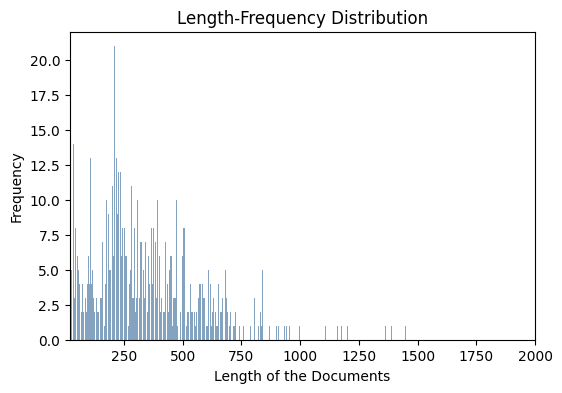

Maximum Length of a Document: 4410
Minimum Length of a Document: 21
Average Length of a Document: 338.0


In [16]:
import matplotlib
matplotlib.rc_file_defaults()
frequency = dict()
for i in dataset.Length:
    frequency[i] = frequency.get(i, 0)+1

plt.figure(figsize = (6,4))
plt.bar(frequency.keys(), frequency.values(), color=(0.2, 0.4, 0.6, 0.6))
plt.xlim(21, 2000)
# in this notbook color is not working but it should work.
plt.xlabel('Length of the Documents')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
#plt.savefig(path+'len_dist.png',dpi = 1000,bbox_inches ='tight')
plt.show()
print(f"Maximum Length of a Document: {max(dataset.Length)}")
print(f"Minimum Length of a Document: {min(dataset.Length)}")
print(f"Average Length of a Document: {round(np.mean(dataset.Length),0)}")

# **Dataset Summary**

In [17]:
def data_summary(dataset):
  '''
  This function will print the summary of the dataset

  Args:
  dataset: cleaned texts

  returns:
  documents: Number of document per class
  words: Number of words per class
  u_words: Number of unique words per class
  class_label: name of the categories
  '''
  documents = []
  words = []
  u_words = []
  #total_u_word = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
  # find class names
  class_label = [k for k,v in dataset.Label.value_counts().to_dict().items()]
  for label in class_label:
    word_list = [word.strip().lower() for t in list(dataset[dataset.Label==label].cleaned) for word in t.strip().split()]
    counts = dict()
    for word in word_list:
      counts[word] = counts.get(word, 0)+1
    # sort the dictionary of word list
    ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
    # Documents per class
    documents.append(len(list(dataset[dataset.Label==label].cleaned)))
    # Total Word per class
    words.append(len(word_list))
    # Unique words per class
    u_words.append(len(np.unique(word_list)))

    print("\nClass Name : ",label)
    print("Number of Documents:{}".format(len(list(dataset[dataset.Label==label].cleaned))))
    print("Number of Words:{}".format(len(word_list)))
    print("Number of Unique Words:{}".format(len(np.unique(word_list))))
    print("Most Frequent Words:\n")
    for k,v in ordered[:10]:
      print("{}\t{}".format(k,v))
  return documents,words,u_words,class_label

# pass the whole dataset into the function

documents,words,u_words,class_names = data_summary(dataset)



Class Name :  0
Number of Documents:1196
Number of Words:406171
Number of Unique Words:38066
Most Frequent Words:

তার	4574
এই	4122
না	4109
করে	3943
আর	2964
এক	2581
সে	2456
কিন্তু	2136
হয়	2093
যে	1955

Class Name :  1
Number of Documents:701
Number of Words:274000
Number of Unique Words:26999
Most Frequent Words:

এই	2680
তার	2604
এক	2237
আর	2235
করে	2214
না	2044
কিন্তু	1600
থেকে	1430
একটা	1370
সে	1353

Class Name :  2
Number of Documents:497
Number of Words:148845
Number of Unique Words:16122
Most Frequent Words:

তার	2002
করে	1674
না	1507
এই	1433
আর	1317
সে	1077
এক	922
কিন্তু	875
হয়	866
একটা	841

Class Name :  4
Number of Documents:410
Number of Words:137589
Number of Unique Words:14949
Most Frequent Words:

করে	1591
এই	1439
তার	1435
না	1195
আর	1104
এক	1076
সে	896
কিন্তু	896
থেকে	885
হয়	782

Class Name :  3
Number of Documents:327
Number of Words:96232
Number of Unique Words:16274
Most Frequent Words:

ও	994
এই	868
করে	859
তিনি	798
না	677
এবং	654
থেকে	615
তার	610
আর	440
যে	430

Clas

In [18]:
data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
data_matrix

,Total Documents,Total Words,Unique Words,Class Names
0,1196,406171,38066,0
1,701,274000,26999,1
2,497,148845,16122,2
3,410,137589,14949,4
4,327,96232,16274,3
5,297,102828,17427,5
6,196,58641,10822,6


# **Data Summary Visualization**

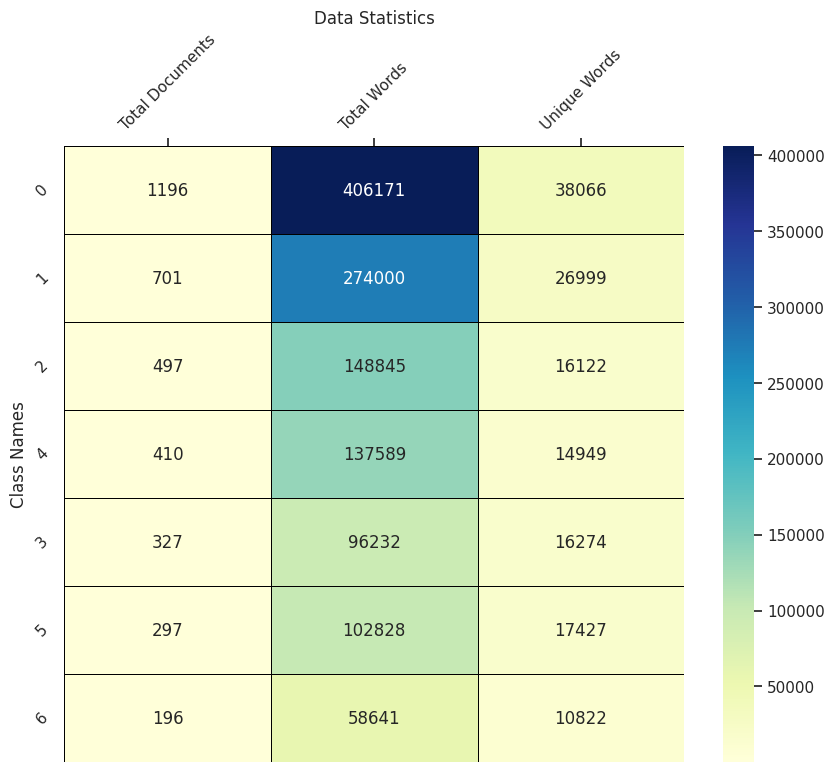

In [19]:
sns.set()
plt.figure(figsize =(10, 8))
ax = plt.subplot()
sns.heatmap(data_matrix.iloc[:,0:3], annot=True,fmt="d", linewidths=0.5,linecolor = 'Black',cmap = "YlGnBu",ax = ax)
# labels, title and ticks
ax.set_ylabel('Class Names')
ax.set_title('Data Statistics')
y_label = ["Total Documents", "Total Words", "Unique Words"]
ax.xaxis.set_ticklabels(y_label, rotation=45); ax.yaxis.set_ticklabels(class_names, rotation=45);
ax.xaxis.tick_top()


# **Dataset Splitting**

In [20]:
dataset[['cleaned']]

,cleaned
0,বইঃ চাঁদের পাহাড় ধরনঃ অ্যাডভে...
1,বেশির ভাগ বই ই আমার ভাললাগে কিন্তু এই টাইপের ...
2,মিসির আলি এখন তার ছাত্র ফারুকের শ্বশুর বাড়ি কই...
3,ছোটজাতের ছোটজাত হাসিম পিতৃপ্রদত্ত নামখানা একর...
4,রকমারি বইপোকা রিভিউ প্রতিযোগিতা বইয়ের নামঃ...
...,...
3619,বিশ্ববিদ্যালয়ের অভ্যন্তরীণ কিছু ঘটনা কিছু মা...
3620,২০০৫ সালে সপ্তম শ্রেণীতে উঠে সাপ্তাহিক বই পড়া ...
3621,আবহমান গ্রাম বাংলার একটি একান্নবর্তী পরিবারের ...
3622,আমার মত যারা ৯০ র দশকে জন্ম তারা আমরা অনেকেই ১...


In [21]:
# Separate features and labels in the training set
X = dataset[['cleaned']]  # Adjust 'target_variable' to your actual target column
y = dataset[['Label']]

In [22]:

def dataset_split(summary,Label):

  X_train,X_valid,y_train,y_valid = train_test_split(summary,Label,train_size = 0.8,
                                                  test_size = 0.2,random_state =0)
  print(color.BOLD+"Feature Size :======>"+color.END,X_train.shape[1])
  print(color.BOLD+"\nDataset Distribution:\n"+color.END)
  print("\tSet Name","\t\tSize")
  print("\t========\t\t======")

  print("\tFull\t\t\t",summary.shape[0],
        "\n\tTraining\t\t",X_train.shape[0],
        "\n\tValidation\t\t",X_valid.shape[0])

  return X_train,X_valid,y_train,y_valid


# **Tokenizer**

In [23]:
def encoded_texts(dataset,padding_length,max_words):

  '''
  This function will encoded the text into a sequence of numbers

  Args:
  dataset: a dataset
  padding_length: maximum length of a encoded texte
  max_words : Number of words

  returns:
  corpus: Number of encoded texts
  labels: encoded labels
  '''

  tokenizer = Tokenizer(num_words = max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n-',
                      split=' ', char_level=False, oov_token='', document_count=0)



 # Fit the tokenizer
  tokenizer.fit_on_texts(dataset.cleaned)
  #============================== Tokenizer Info =================================
  (word_counts,word_docs,word_index,document_count) = (tokenizer.word_counts,
                                                       tokenizer.word_docs,
                                                       tokenizer.word_index,
                                                       tokenizer.document_count)
  def tokenizer_info(mylist,bool):
    ordered = sorted(mylist.items(), key= lambda item: item[1],reverse = bool)
    for w,c in ordered[:10]:
      print(w,"\t",c)
  #=============================== Print all the information =========================
  print(color.BOLD+"\t\t\t====== Tokenizer Info ======"+color.END)
  print("Words --> Counts:")
  tokenizer_info(word_counts,bool =True )
  print("\nWords --> Documents:")
  tokenizer_info(word_docs,bool =True )
  print("\nWords --> Index:")
  tokenizer_info(word_index,bool =True )
  print("\nTotal Documents -->",document_count)

  #=========================== Convert string into list of integer indices =================
  sequences = tokenizer.texts_to_sequences(dataset.cleaned)
  word_index = tokenizer.word_index
  print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\nFound {} unique tokens".format(len(word_index)))
  print(dataset.cleaned[10],"\n",sequences[10])

  #==================================== Pad Sequences ==============================
  corpus = keras.preprocessing.sequence.pad_sequences(sequences, value=0.0,
                                                      padding='post', maxlen= padding_length)
  print("\n\t\t\t====== Paded Sequences ======\n",dataset.cleaned[10],"\n",corpus[10])

  labels=  dataset['Label']

  return corpus, labels

#call the function
num_words = 5000
corpus,labels = encoded_texts(dataset,
                                4000,num_words)
print("\nShape of Encoded Corpus =====>",corpus.shape)

			====== Tokenizer Info ======
Words --> Counts:
তার 	 12295
এই 	 12002
করে 	 11821
না 	 10913
আর 	 8898
এক 	 7760
ও 	 6719
থেকে 	 6551
সে 	 6321
কিন্তু 	 6249

Words --> Documents:
এই 	 2958
করে 	 2920
তার 	 2718
না 	 2708
এক 	 2539
আর 	 2534
থেকে 	 2512
কিন্তু 	 2336
যে 	 2224
এবং 	 2075

Words --> Index:
ভিপি 	 73369
ডাকসুর 	 73368
ঊপন্যাস 	 73367
সাহিত্যকৃতী 	 73366
পূরনো 	 73365
আম্বিয়া 	 73364
আম্বিয়াকে 	 73363
সার্কাসের 	 73362
পুথিপাঠ 	 73361
সুনিখুত 	 73360

Total Documents --> 3624

			====== Encoded Sequences ====== 
Found 73369 unique tokens
প্রথম প্রশ্ন  আপনি কি বাচ্চাকাচ্চা অপছন্দ করেন  তাদের কৌতুহলী প্রশ্নে বিরক্ত বোধ করেন  দ্বিতীয় প্রশ্ন   ছোটদের কাজকে আপনার অযৌক্তিক বলে মনে হয়  অল্প বয়সেই বেশি বুদ্ধিমান বাচ্চাকে ইঁচড়েপাকা বলে মনে হয় তবে প্লিজ আপনি এই বই পড়বেন না  বইটি আপনার জন্য না  আপনি বরং আপনার বুড়ো মন আর রাশভারী মেজাজ নিয়েই থাকুন আর এদিকে আমরা  বাবাকোয়া  দের পৃথিবীতে উঁকি দিয়ে আসি  ছোট্ট বাবাই  বয়স যার মাত্র ৫ বছর  সে নিজেকে সবার কাছে  ক্যাপ্টেন বাবাক

# **Call Dataset Split Function**

In [24]:

X_train,X_valid,y_train,y_valid = dataset_split(corpus,labels)

Feature Size :======> 4000

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 3624 
	Training		 2899 
	Validation		 725


# **solving the imbalance class**

In [25]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(dataset['Label']),
    y=dataset['Label']
)

# Convert class weights to dictionary
class_weight_dict = {class_label: weight for class_label, weight in zip(np.unique(dataset['Label']), class_weights)}


# **--------------TF-IDF & ML classifiers**

In [ ]:
!pip install -U imbalanced-learn


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score

# Assuming you have a DataFrame 'df' with 'text' as the input text and 'label' as the class label
# Make sure your 'label' column contains integer-encoded class labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset['cleaned'], dataset['Label'], test_size=0.2, random_state=42)

# Convert text data to TF-IDF features
max_features = 5000  # Adjust this based on your data
tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Apply oversampling to balance the classes
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_tfidf, y_train)

# Define classifiers
classifiers = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
}

# Dictionary to store trained models
trained_models = {}

# Train and evaluate each classifier
for name, classifier in classifiers.items():
    print(f"Training {name}...")
    classifier.fit(X_train_resampled, y_train_resampled)

    # Save the trained model to the dictionary
    trained_models[name] = classifier

    # Predictions
    y_pred = classifier.predict(X_test_tfidf)

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    report = classification_report(y_test, y_pred)

    print(f"\nResults for {name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Macro F1-Score:", macro_f1)
    print("Classification Report:\n", report)
    print("=" * 50)

# Now 'trained_models' contains your trained models, and you can use them for predictions on new data.



### **hepertuned Logistic regression**

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 200, 300, 400, 500],
}

# Create the Logistic Regression model
logreg_model = LogisticRegression(C=100, penalty='l2', max_iter=1000)

# Create GridSearchCV object
grid_search = GridSearchCV(logreg_model, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Perform the grid search on the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters found by the grid search
print("Best Parameters:", grid_search.best_params_)

# Get the best model from the grid search
best_logreg_model = grid_search.best_estimator_

# Now you can use best_logreg_model for predictions on your test data
y_pred_best = best_logreg_model.predict(X_test_tfidf)

# Evaluate performance
accuracy_best = accuracy_score(y_test, y_pred_best)
macro_f1_best = f1_score(y_test, y_pred_best, average='macro')
report_best = classification_report(y_test, y_pred_best)

print("\nResults for Best Logistic Regression Model:")
print(f"Accuracy: {accuracy_best:.4f}")
print("Macro F1-Score:", macro_f1_best)
print("Classification Report:\n", report_best)
print("=" * 50)


### **hypertuned SVM**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define a smaller parameter grid
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
}

# Create the SVM model
svm_model = SVC()

# Create GridSearchCV object
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='f1_macro', n_jobs=-1)

# Perform the grid search on the resampled training data
grid_search_svm.fit(X_train_resampled, y_train_resampled)

# Print the best parameters found by the grid search
print("Best Parameters for SVM:", grid_search_svm.best_params_)

# Get the best model from the grid search
best_svm_model = grid_search_svm.best_estimator_

# Now you can use best_svm_model for predictions on your test data
y_pred_svm_best = best_svm_model.predict(X_test_tfidf)

# Evaluate performance
accuracy_svm_best = accuracy_score(y_test, y_pred_svm_best)
macro_f1_svm_best = f1_score(y_test, y_pred_svm_best, average='macro')
report_svm_best = classification_report(y_test, y_pred_svm_best)

print("\nResults for Best SVM Model:")
print(f"Accuracy: {accuracy_svm_best:.4f}")
print("Macro F1-Score:", macro_f1_svm_best)
print("Classification Report:\n", report_svm_best)
print("=" * 50)


### **Hypertuned XGBoost**

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Define a larger parameter grid for XGBoost
param_grid_xgboost = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# Create the XGBoost model
xgboost_model = XGBClassifier()

# Create GridSearchCV object
grid_search_xgboost = GridSearchCV(xgboost_model, param_grid_xgboost, cv=5, scoring='f1_macro', n_jobs=-1)

# Perform the grid search on the resampled training data
grid_search_xgboost.fit(X_train_resampled, y_train_resampled)

# Print the best parameters found by the grid search
print("Best Parameters for XGBoost:", grid_search_xgboost.best_params_)

# Get the best model from the grid search
best_xgboost_model = grid_search_xgboost.best_estimator_

# Now you can use best_xgboost_model for predictions on your test data
y_pred_xgboost_best = best_xgboost_model.predict(X_test_tfidf)

# Evaluate performance
accuracy_xgboost_best = accuracy_score(y_test, y_pred_xgboost_best)
macro_f1_xgboost_best = f1_score(y_test, y_pred_xgboost_best, average='macro')
report_xgboost_best = classification_report(y_test, y_pred_xgboost_best)

print("\nResults for Best XGBoost Model:")
print(f"Accuracy: {accuracy_xgboost_best:.4f}")
print("Macro F1-Score:", macro_f1_xgboost_best)
print("Classification Report:\n", report_xgboost_best)
print("=" * 50)



**Checking on test data**

In [ ]:
# Assuming you have new test data in X_new_text

# Convert the new text data to TF-IDF features using the same vectorizer
X_new_tfidf = tfidf_vectorizer.transform(dataset_test['cleaned'])

# Dictionary to store predictions
predictions = {}

# Make predictions using each trained model
for name, model in trained_models.items():
    y_pred = model.predict(X_new_tfidf)
    predictions[name] = y_pred


In [ ]:
test_prediction=predictions['Logistic Regression']
test_prediction

In [27]:
num_classes= len(dataset['Label'].unique())
num_classes

7

In [28]:
class_labels = dataset['Label'].unique().astype(str)


# -------------------------CNN + BiLSTM----------------------------

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Assuming you have a DataFrame 'df' with 'cleaned' as the input text and 'Label' as the class label
# Make sure your 'Label' column contains integer-encoded class labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset['cleaned'], dataset['Label'], test_size=0.2, random_state=42)

# Tokenize the text data
max_words = 5000  # Adjust this based on your data
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text data to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to have the same length
max_len = 1000  # Adjust this based on your data
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')



# Define the model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=150, input_length=max_len))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Calculate class weights to handle imbalanced classes
class_weights = class_weight.compute_class_weight('balanced', classes=range(num_classes), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
model.fit(X_train_padded, y_train, epochs=15, batch_size=32, validation_split=0.1, class_weight=class_weight_dict)
#callbacks=[early_stopping]

# Evaluate the model
y_pred_probs = model.predict(X_test_padded)
y_pred = y_pred_probs.argmax(axis=1)
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
report = classification_report(y_test, y_pred, target_names=class_labels)


print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
print("Classification Report:\n", report)



Epoch 1/15
82/82 [==============================] - 15s 137ms/step - loss: 1.8775 - accuracy: 0.1775 - val_loss: 1.6302 - val_accuracy: 0.3621
Epoch 2/15
82/82 [==============================] - 10s 127ms/step - loss: 1.3468 - accuracy: 0.4255 - val_loss: 1.2180 - val_accuracy: 0.5690
Epoch 3/15
82/82 [==============================] - 10s 127ms/step - loss: 0.7263 - accuracy: 0.7443 - val_loss: 0.7630 - val_accuracy: 0.7621
Epoch 4/15
82/82 [==============================] - 11s 130ms/step - loss: 0.3440 - accuracy: 0.8842 - val_loss: 0.6469 - val_accuracy: 0.7759
Epoch 5/15
82/82 [==============================] - 10s 127ms/step - loss: 0.1880 - accuracy: 0.9417 - val_loss: 0.6973 - val_accuracy: 0.7621
Epoch 6/15
82/82 [==============================] - 11s 129ms/step - loss: 0.1306 - accuracy: 0.9609 - val_loss: 0.8279 - val_accuracy: 0.7828
Epoch 7/15
82/82 [==============================] - 11s 129ms/step - loss: 0.1061 - accuracy: 0.9659 - val_loss: 0.7134 - val_accuracy: 0.8034

# Processing test data

In [ ]:
dataset_test= test[['summary']]

In [ ]:
dataset_test['cleaned']= dataset_test.summary.apply(cleaning)

In [ ]:
dataset_test

In [ ]:
# Replace missing values with an empty string
dataset_test['cleaned'].fillna('', inplace=True)


In [ ]:
%%time
max_words = 100000

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n-', split=' ')


tokenizer.fit_on_texts(dataset_test['cleaned'])

In [ ]:
tokenized_sequences = tokenizer.texts_to_sequences(dataset_test['cleaned'])


In [ ]:
%%time
## Before padding length of different training examples
max_len_test = max([len(x) for x in tokenized_sequences])
print("Maximum Text length",max_len)

##We can also determine maxlen by plotting the frequency distribution of the lengths
corpus_test = keras.preprocessing.sequence.pad_sequences(tokenized_sequences, value=0.0, padding='post', maxlen= 4410)
## We get the maxlen value from the Length frequency distribution

print(corpus_test[1])

# ------------------------Prediction

# Submission

In [ ]:
submission= test[["Id"]]
submission

In [ ]:
submission["Label"]=test_prediction

In [ ]:
submission

In [ ]:
submission.to_csv("submission.csv",index=None)

In [ ]:
pd.read_csv('submission.csv')